# Forecasting
Contents:
- Univariate time series forecasting
- Univariate time series forecasting with exogenous variables
- Multivariate time series forecasting


In [1]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

## Univariate forecasting: a basic workflow
In forecasting, we are interested in using past data to make temporal forward predictions. Sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.

The **basic workflow** for forecasting is generating one single prediction for a single point in time
1. Specify the data
2. Specify the task
3. Split the data
4. Specify the model
5. Fit
6. Predict
7. Evaluate

### 1. Specify the data


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

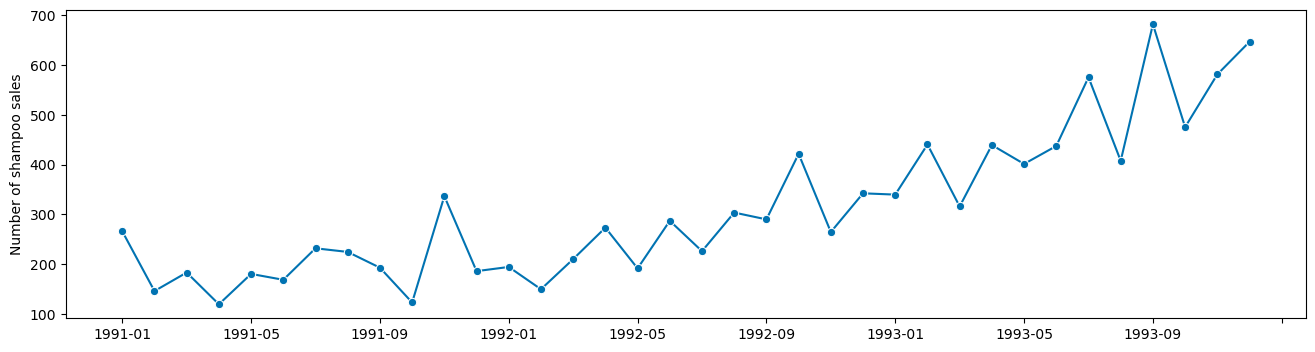

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

plot_series(y)

### 2. Task specification
Define a forecasting task; in the example:
- Try to predict the last 6 months of data, using the previous data as training data. Each point in the time series represents a month, so the last 6 points should be hold out as test data, and a 6-step ahead forecasting horizon should be used to evaluate the forecasting performance.
- The metric chosen to quantify the accuracy of the forecast is MAPE (mean absolute percentage error). A lower MAPE means higher accuracy.

#### Forecasting horizon
When forecasts are generated, a forecasting horizon has to be specified and passed as a parameter to the forecasting algorithm. The forecasting horizon can be specified as a numpy array of the steps ahead relative to the end of the training series:

**Using an array of values**


In [3]:
import numpy as np

fh = np.arange(6) + 1
fh

array([1, 2, 3, 4, 5, 6])

**Using the ForecastingHorizon object**


In [4]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(
    pd.period_range('1993-07', periods=6, freq='M'),
    is_relative=False
)
fh

ForecastingHorizon(['1993-07', '1993-08', '1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]', is_relative=False)

In [5]:
cutoff = pd.Period('1993-06', freq='M')
fh.to_relative(cutoff)

ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True)

### 3. Split the data
Split the data into train, test, and split datasets


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

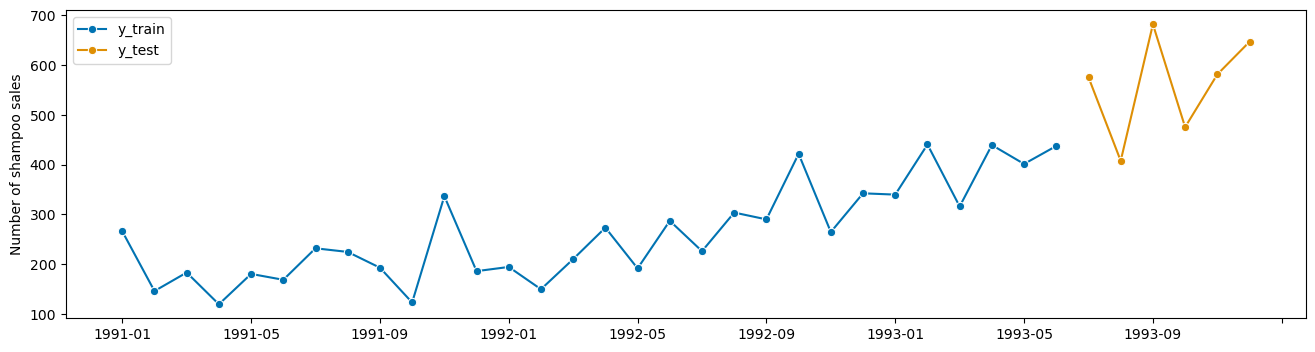

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

plot_series(y_train, y_test, labels=['y_train', 'y_test'])

### 4. Model specification


In [7]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='drift', window_length=10)

### 5. Fitting


In [8]:
forecaster.fit(y_train)

NaiveForecaster(strategy='drift', window_length=10)

Notice that the `fit` method is different from the one in sklearn


In [9]:
forecaster.fit?

Signature: forecaster.fit(y, X=None, fh=None)
Docstring:
Fit forecaster to training data.

State change:
    Changes state to "fitted".

Writes to self:
    Sets self._is_fitted flag to True.
    Writes self._y and self._X with `y` and `X`, respectively.
    Sets self.cutoff and self._cutoff to last index seen in `y`.
    Sets fitted model attributes ending in "_".
    Stores fh to self.fh if fh is passed.

Parameters
----------
y : time series in sktime compatible data container format
        Time series to which to fit the forecaster.
    y can be in one of the following formats:
    Series scitype: pd.Series, pd.DataFrame, or np.ndarray (1D or 2D)
        for vanilla forecasting, one time series
    Panel scitype: pd.DataFrame with 2-level row MultiIndex,
        3D np.ndarray, list of Series pd.DataFrame, or nested pd.DataFrame
        for global or panel forecasting
    Hierarchical scitype: pd.DataFrame with 3 or more level row MultiIndex
        for hierarchical forecasting
   

1. the first argument is the target series `y`
2. the second argument is exogenous data (see below)
3. the third argument is the forecasting horizon; it is not required for all models to pass the forecasting horizon in the fitting step 

### 6. Predicting


In [10]:
y_pred = forecaster.predict(fh)

### 7. Evaluating


In [11]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.16469764622516225

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

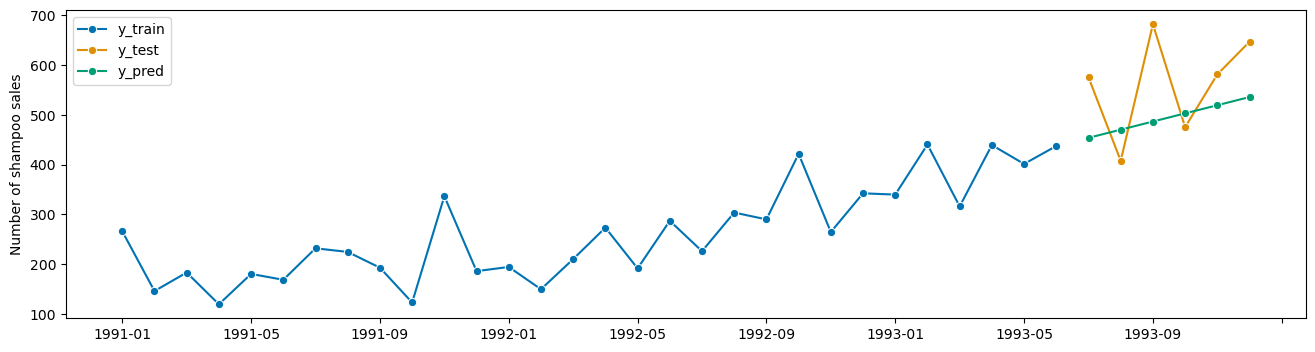

In [12]:
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

### Another example using the ARIMA model


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

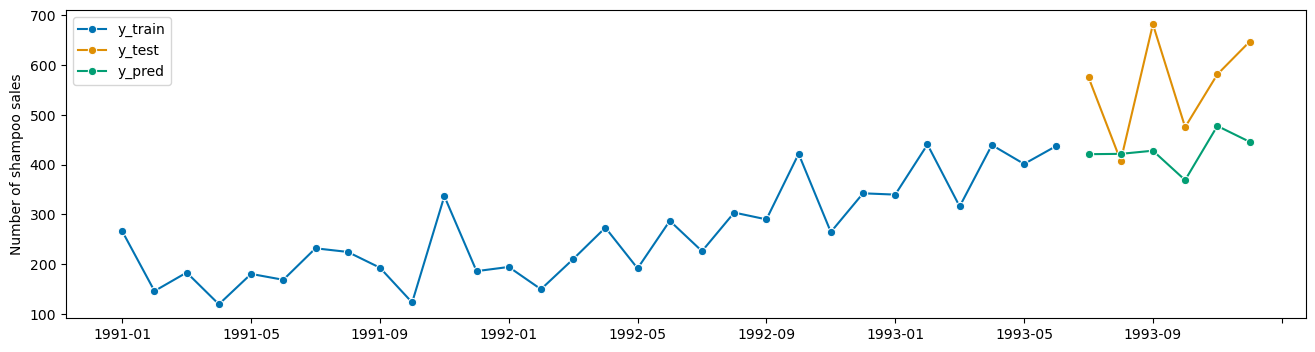

In [13]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import numpy as np

# data load
y = load_shampoo_sales()

# task specification: forecasting 6 months ahead
fh = np.arange(6) + 1

# split the data
y_train, y_test = temporal_train_test_split(y, fh=fh)

# model specification
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

# model fit
forecaster.fit(y_train)

# model predict
y_pred = forecaster.predict(fh)

# model evaluation
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

In [14]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.23140725522776395

### Summary of the basic workflow
- single, fixed cutoff point at which predictions are generated
- common interface for forecasters

### Forecasters in sktime
The complete list of sktime estimators is available [here](https://www.sktime.org/en/stable/estimator_overview.html)


In [15]:
from sktime.registry import all_estimators

# all_estimators('forecaster', as_dataframe=True)

### Is it possible to just use scikit-learn?
Using sklearn alone with time series data tasks has many pitfalls. It is better to use it together with sktime, since it provides a meta-estimator for this approach, that is:
- **modular** and **compatible with scikit-learn**, so that it is possible to easily apply any scikt-learn regressor to solve a forecasting problem
- **parametric** and **tuneable**, allowing to tune hyperparameters like the window length or the strategy to generate forecasts
- **adaptive**, in the sense that it adapts the scikit-learn estimator interface to that of a forecaster, making sure that the model can be properly tuned and evaluated


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

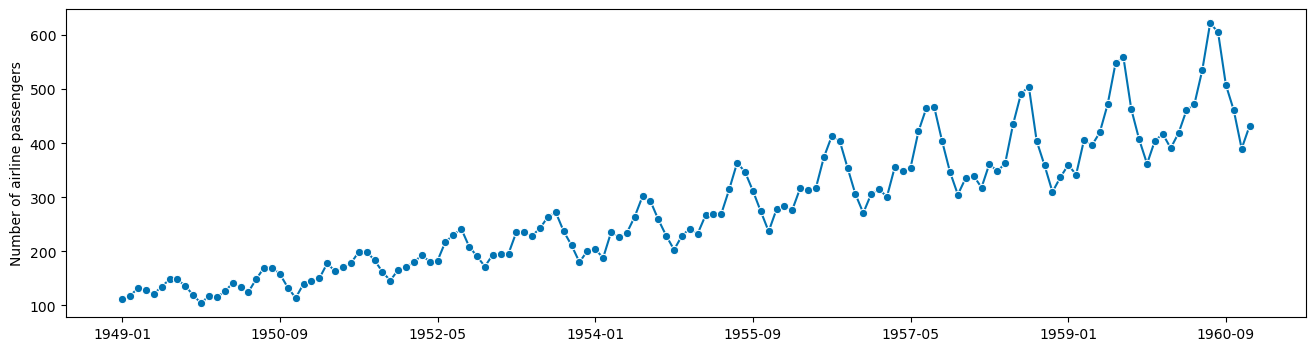

In [16]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# data load
y = load_airline()
plot_series(y)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

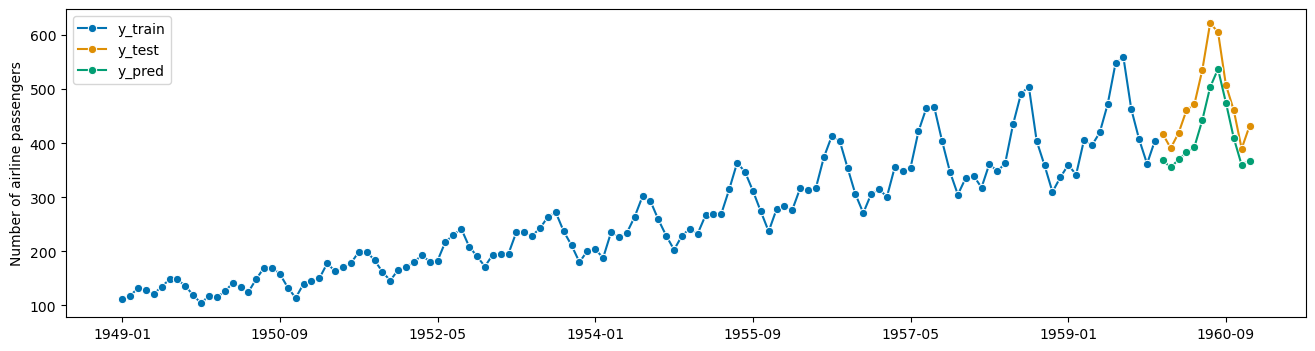

In [17]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# model task and data split
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# model specification
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy='recursive', window_length=12) 

# model fit
forecaster.fit(y_train, fh=fh)

# model predict
y_pred = forecaster.predict()

# model evaluation
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

In [18]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.12825559519541507

Notice that the function `make_reduction` wraps around a regressor and makes it possible to use it as a forecaster


## Univariate forcasting: a more advanced workflow
1. Specify the data
2. Specify the task
3. Split the data
4. Specify the model
5. Fit
6. Predict
7. Observe new data
8. Update using new data
9. Repeat steps 6 to 8 as often as required

### 1. Specify the data

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

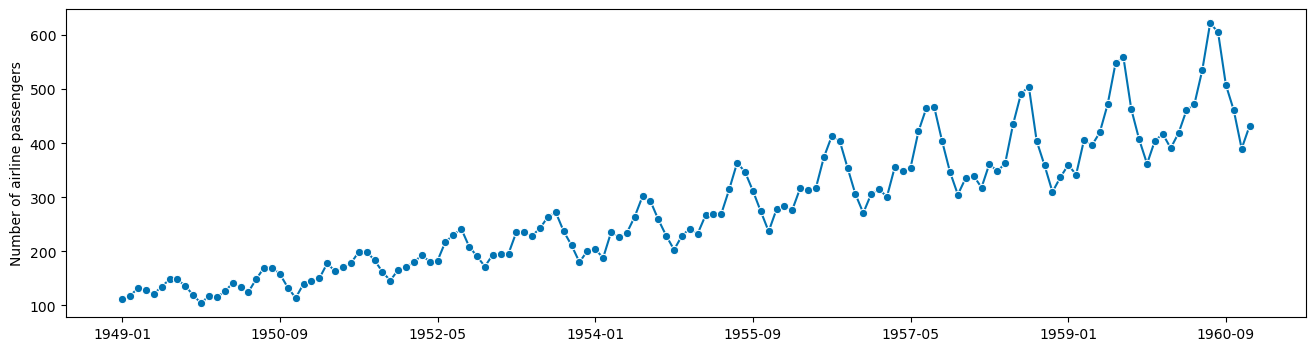

In [21]:
from sktime.datasets import load_airline

y = load_airline()
plot_series(y)

### 2. Task specification
The task is to predict one year ahead, one point per month

In [22]:
fh = np.arange(1,13)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### 3. Model split

In [28]:
y_train = y.loc[:'1957-08']
y_observed = y_train.copy() # these are the data that I consider received until now
y_observed.tail()

1957-04    348.0
1957-05    355.0
1957-06    422.0
1957-07    465.0
1957-08    467.0
Freq: M, Name: Number of airline passengers, dtype: float64

### 4. Model specification

In [25]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

### 5. Model fit

In [26]:
forecaster.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

### 6. Model predict

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

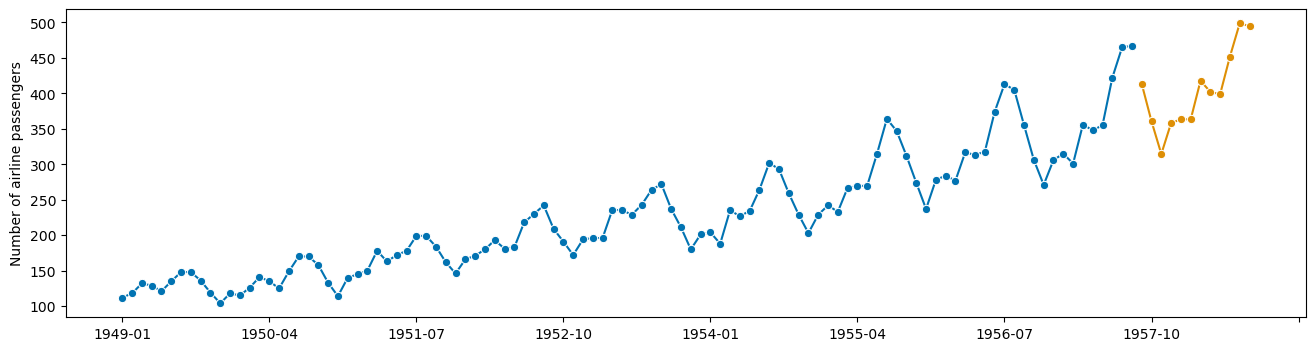

In [27]:
y_pred = forecaster.predict(fh)

plot_series(y_observed,y_pred)

### 7. Observe new data 

In [29]:
y_observed = y.loc[:'1957-09']
new_data = y.loc[['1957-09']]
new_data

1957-09    404.0
Freq: M, Name: Number of airline passengers, dtype: float64

### 8. Model update

In [30]:
forecaster.update(new_data)

d:\Miniconda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_base.py:1640: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called with update_params=True.
  warn(


AutoETS(auto=True, n_jobs=-1, sp=12)

Notice the warning: this type of model does not have a specific `update` method, so it resorts to refitting the model from scratch

### 6. Model predict (after update)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

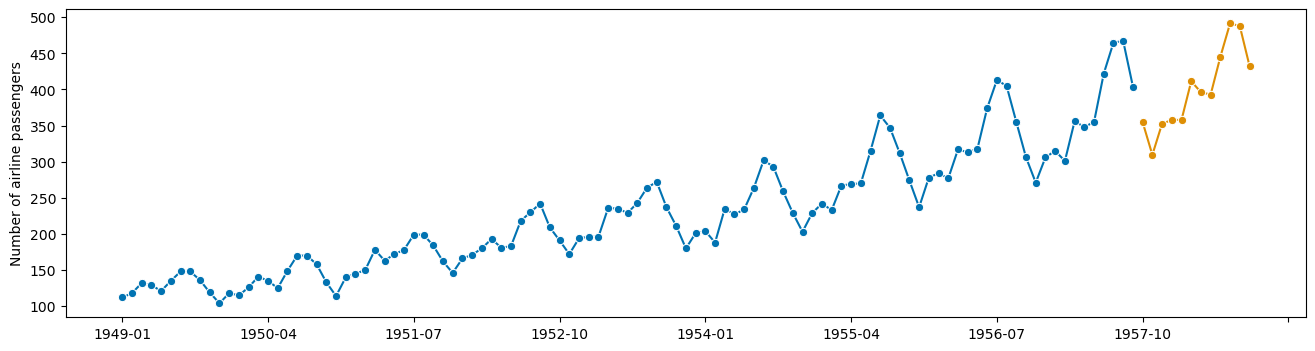

In [31]:
y_pred = forecaster.predict(fh)

plot_series(y_observed,y_pred)

#### Documentation on `update`

In [32]:
forecaster.update?

Signature: forecaster.update(y, X=None, update_params=True)
Docstring:
Update cutoff value and, optionally, fitted parameters.

If no estimator-specific update method has been implemented,
default fall-back is as follows:
    update_params=True: fitting to all observed data so far
    update_params=False: updates cutoff and remembers data only

State required:
    Requires state to be "fitted".

Accesses in self:
    Fitted model attributes ending in "_".
    Pointers to seen data, self._y and self.X
    self.cutoff, self._is_fitted
    If update_params=True, model attributes ending in "_".

Writes to self:
    Update self._y and self._X with `y` and `X`, by appending rows.
    Updates self. cutoff and self._cutoff to last index seen in `y`.
    If update_params=True,
        updates fitted model attributes ending in "_".

Parameters
----------
y : time series in sktime compatible data container format
        Time series to which to fit the forecaster in the update.
    y can be in on

If the parameter `update_params` of `update` is set to `False`, the model is not refitted, and just the cutoff is updated

## Automating the process
sktime helps o automate the workflow

In [37]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.utils.plotting import plot_windows

y = load_airline()
fh = ForecastingHorizon(np.arange(12) + 1)
y_train, y_test = temporal_train_test_split(y, fh=fh)

In [38]:
from sktime.utils.validation._dependencies import _check_soft_dependencies

def _get_windows(cv, y):
    """Generate cv split windows, utility function."""
    train_windows = []
    test_windows = []
    for train, test in cv.split(y):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

def plot_windows(cv, y, title=""):
    """Plot training and test windows.
    Parameters
    ----------
    y : pd.Series
        Time series to split
    cv : temporal cross-validation iterator object
        Temporal cross-validation iterator
    title : str
        Plot title
    """
    _check_soft_dependencies("matplotlib", "seaborn")
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import MaxNLocator

    simplefilter("ignore", category=UserWarning)

    train_windows, test_windows = _get_windows(cv, y)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels)

### Temporal cross-validation

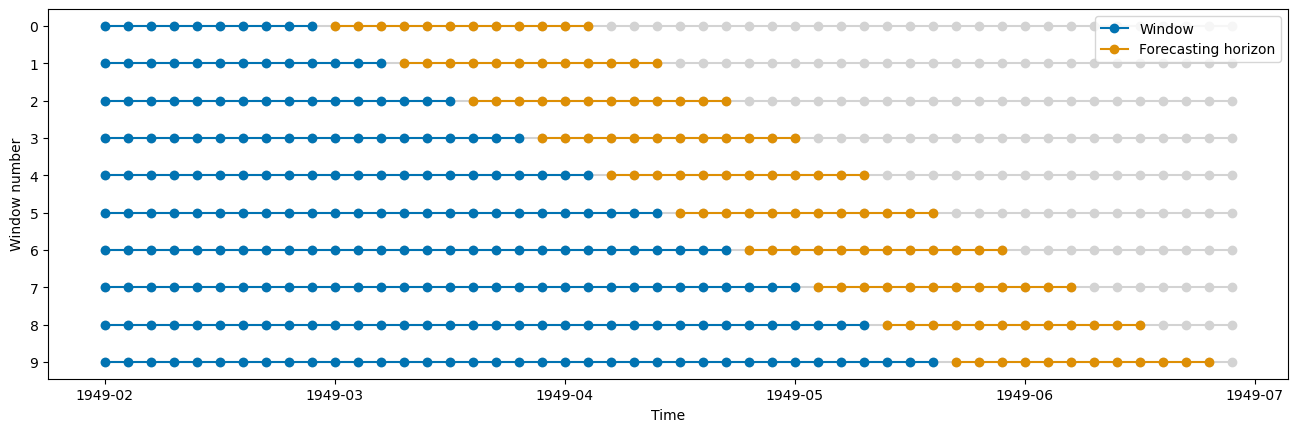

In [39]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter

cv = ExpandingWindowSplitter(step_length=3, fh=fh, initial_window=10)
plot_windows(cv, y.iloc[:50])

So, the `ExpandingWindowSplitter` class helps to create windows that expand, setting an initial window width (`initial_window`) and a step of expansion (`step_length`)